<a href="https://colab.research.google.com/github/RexAgarwal/new/blob/main/Battery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


In [5]:
df = pd.read_csv('Battery_Data.csv')


In [7]:
display(df.head(10))

,Unnamed: 0,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
0,0,1,24,2008-04-02 15:25:41,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000
1,1,1,24,2008-04-02 15:25:41,1.856487,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781
2,2,1,24,2008-04-02 15:25:41,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703
3,3,1,24,2008-04-02 15:25:41,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781
4,4,1,24,2008-04-02 15:25:41,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922
5,5,1,24,2008-04-02 15:25:41,1.856487,3.920058,-2.013007,24.909816,-1.9982,2.991,90.094
6,6,1,24,2008-04-02 15:25:41,1.856487,3.907904,-2.014400,25.105884,-1.9982,2.977,108.281
7,7,1,24,2008-04-02 15:25:41,1.856487,3.897036,-2.011603,25.317019,-1.9982,2.967,126.453
8,8,1,24,2008-04-02 15:25:41,1.856487,3.887477,-2.018015,25.509423,-1.9982,2.959,144.641
9,9,1,24,2008-04-02 15:25:41,1.856487,3.878959,-2.013135,25.703603,-1.9982,2.951,162.844


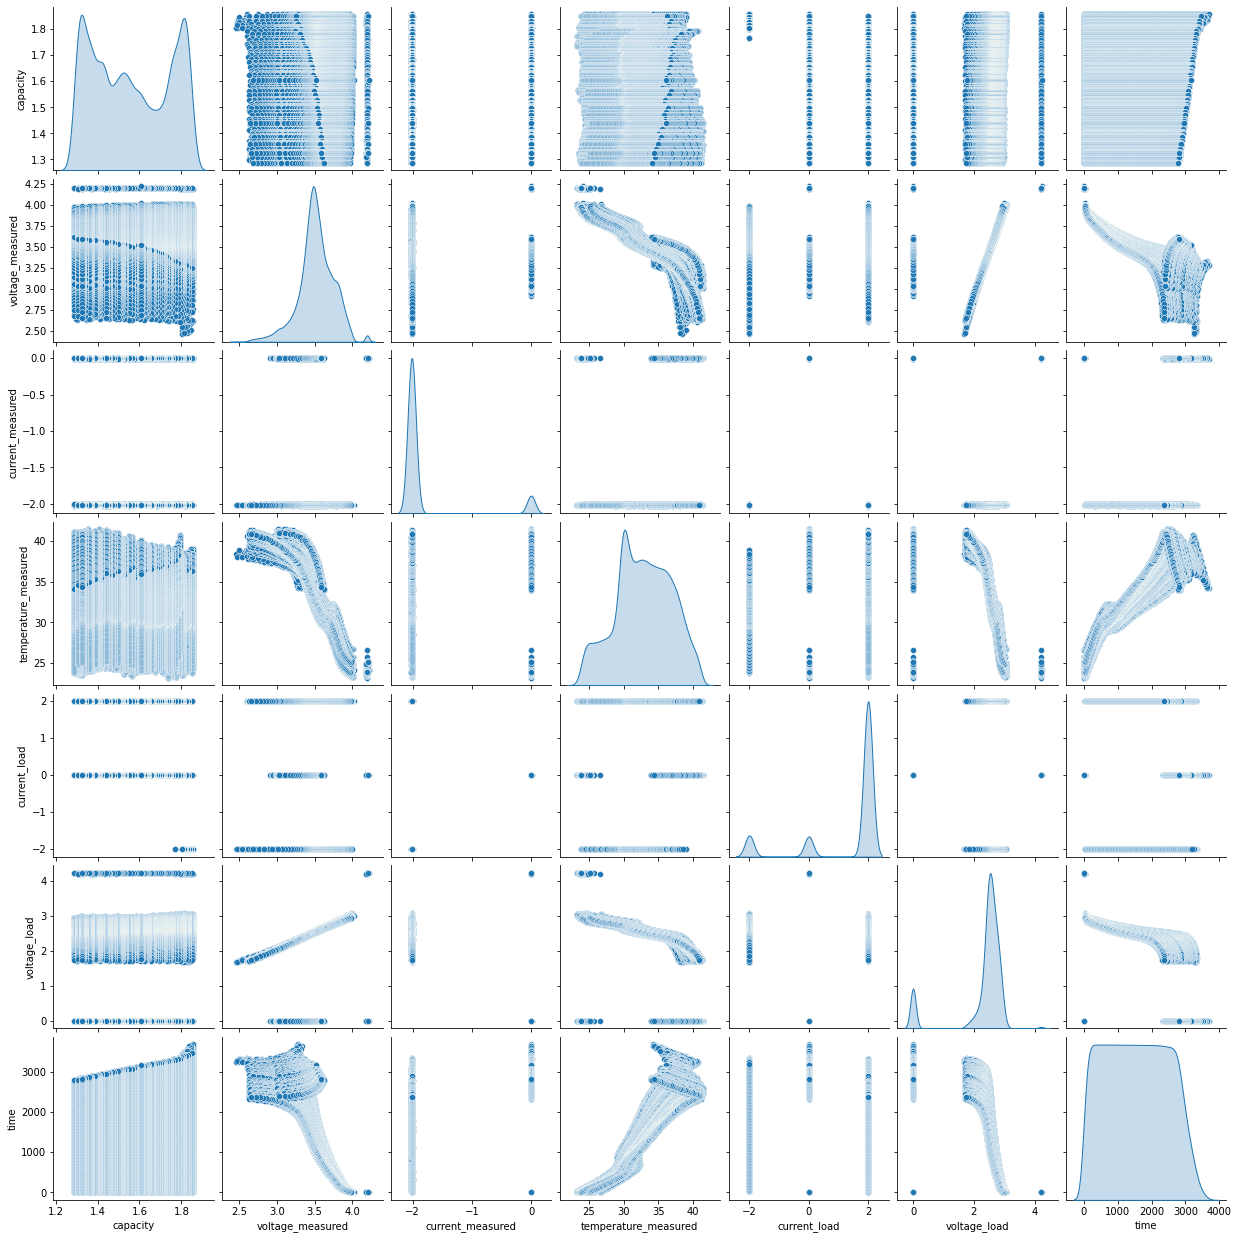

In [14]:
sns.pairplot(df[['capacity', 'voltage_measured', 'current_measured', 'temperature_measured','current_load','voltage_load','time']], diag_kind='kde')

In [24]:
df = df.drop(['datetime'], axis = 1)
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [25]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,40228.0,25150.112161,14511.778202,0.000000,12584.750000,25157.500000,37702.500000,50284.000000
cycle,40228.0,88.146316,45.689988,1.000000,50.000000,88.000000,127.000000,168.000000
ambient_temperature,40228.0,24.000000,0.000000,24.000000,24.000000,24.000000,24.000000,24.000000
capacity,40228.0,1.560183,0.182298,1.287453,1.386229,1.538237,1.746871,1.856487
voltage_measured,40228.0,3.515177,0.231585,2.471315,3.399612,3.511944,3.661578,4.222920
current_measured,40228.0,-1.807150,0.609032,-2.029098,-2.013409,-2.012308,-2.011060,0.007496
temperature_measured,40228.0,32.818942,3.993503,23.214802,30.017912,32.821344,35.927790,41.450232
current_load,40228.0,1.363217,1.314012,-1.998400,1.998000,1.998200,1.998200,1.998400
voltage_load,40228.0,2.309128,0.798821,0.000000,2.387000,2.534000,2.691000,4.238000
time,40228.0,1545.545352,906.813767,0.000000,762.859250,1537.063000,2305.797000,3690.234000


In [26]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('capacity')
test_labels = test_features.pop('capacity')

In [27]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt((np.array(train_features)).astype('float32'))
print(normalizer.mean.numpy())

[[ 2.5150100e+04  8.8146202e+01  2.4000000e+01  3.5151744e+00
  -1.8071502e+00  3.2818932e+01  1.3632149e+00  2.3091245e+00
   1.5455463e+03]]


In [28]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[8226.     38.     24.      3.83   -2.01   27.02    2.      2.86  375.31]]

Normalized: [[-1.17 -1.1   0.    1.35 -0.34 -1.45  0.48  0.69 -1.29]]


In [30]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [31]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [39]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

In [40]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

TypeError: ignored

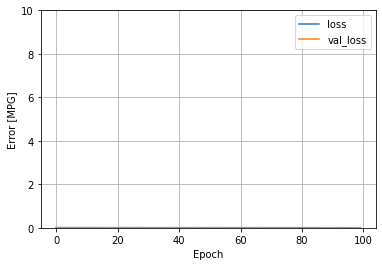

In [50]:
plot_loss(history)

In [56]:
test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)
print("MAE:")
print(test_results)

MAE:
0.0037412371020764112


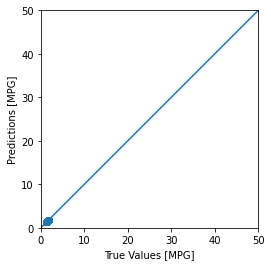

In [43]:
test_predictions = dnn_model.predict(test_features).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

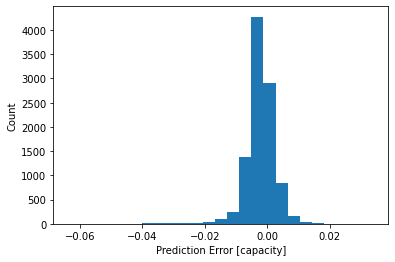

In [53]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [capacity]')
_ = plt.ylabel('Count')